In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split    
from sklearn.metrics import accuracy_score,classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
hrattr_data = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
hrattr_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [7]:
hrattr_data['Attrition_ind'] = 0
hrattr_data.loc[hrattr_data['Attrition']=='Yes','Attrition_ind'] = 1

dummy_busnstrvl = pd.get_dummies(hrattr_data['BusinessTravel'], prefix='busns_trvl')
dummy_dept = pd.get_dummies(hrattr_data['Department'], prefix='dept')
dummy_edufield = pd.get_dummies(hrattr_data['EducationField'], prefix='edufield')
dummy_gender = pd.get_dummies(hrattr_data['Gender'], prefix='gend')
dummy_jobrole = pd.get_dummies(hrattr_data['JobRole'], prefix='jobrole')
dummy_maritstat = pd.get_dummies(hrattr_data['MaritalStatus'], prefix='maritalstat') 
dummy_overtime = pd.get_dummies(hrattr_data['OverTime'], prefix='overtime') 

continuous_columns = ['Age','DailyRate','DistanceFromHome','Education','EnvironmentSatisfaction',
'HourlyRate', 'JobInvolvement', 'JobLevel','JobSatisfaction','MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 
'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction','StockOptionLevel', 'TotalWorkingYears', 
'TrainingTimesLastYear','WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
'YearsWithCurrManager']

hrattr_continuous = hrattr_data[continuous_columns]

hrattr_continuous['Age'].describe()
hrattr_data['BusinessTravel'].value_counts()

hrattr_data_new = pd.concat([dummy_busnstrvl,dummy_dept,dummy_edufield,dummy_gender,dummy_jobrole,
  dummy_maritstat,dummy_overtime,hrattr_continuous,hrattr_data['Attrition_ind']],axis=1)


In [8]:
# Train & Test split
x_train,x_test,y_train,y_test = train_test_split(hrattr_data_new.drop(['Attrition_ind'],axis=1),
                                                 hrattr_data_new['Attrition_ind'],train_size = 0.7,random_state=42)

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dt_fit = DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_split=2,min_samples_leaf=1,random_state=42)
dt_fit.fit(x_train,y_train)

print ("\nDecision Tree - Train Confusion Matrix\n\n",pd.crosstab(y_train,dt_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nDecision Tree - Train accuracy:",round(accuracy_score(y_train,dt_fit.predict(x_train)),3))
print ("\nDecision Tree - Train Classification Report\n",classification_report(y_train,dt_fit.predict(x_train)))

print ("\n\nDecision Tree - Test Confusion Matrix\n\n",pd.crosstab(y_test,dt_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nDecision Tree - Test accuracy:",round(accuracy_score(y_test,dt_fit.predict(x_test)),3))
print ("\nDecision Tree - Test Classification Report\n",classification_report(y_test,dt_fit.predict(x_test)))


Decision Tree - Train Confusion Matrix

 Predicted    0   1
Actuall           
0          844   9
1           98  78

Decision Tree - Train accuracy: 0.896

Decision Tree - Train Classification Report
               precision    recall  f1-score   support

           0       0.90      0.99      0.94       853
           1       0.90      0.44      0.59       176

    accuracy                           0.90      1029
   macro avg       0.90      0.72      0.77      1029
weighted avg       0.90      0.90      0.88      1029



Decision Tree - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          361  19
1           49  12

Decision Tree - Test accuracy: 0.846

Decision Tree - Test Classification Report
               precision    recall  f1-score   support

           0       0.88      0.95      0.91       380
           1       0.39      0.20      0.26        61

    accuracy                           0.85       441
   macro avg       0.63      0.57      0.59       4

In [16]:
# Tuning class weights to analyze accuracy, precision & recall
dummyarray = np.empty((6,10))
dt_wttune = pd.DataFrame(dummyarray)

dt_wttune.columns = ["zero_wght","one_wght","tr_accuracy","tst_accuracy","prec_zero","prec_one",
                     "prec_ovll","recl_zero","recl_one","recl_ovll"]

zero_clwghts = [0.01,0.1,0.2,0.3,0.4,0.5]

for i in range(len(zero_clwghts)):
    clwght = {0:zero_clwghts[i],1:1.0-zero_clwghts[i]}
    dt_fit = DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_split=2,
                                    min_samples_leaf=1,random_state=42,class_weight = clwght)
    dt_fit.fit(x_train,y_train)
    dt_wttune.loc[i, 'zero_wght'] = clwght[0]       
    dt_wttune.loc[i, 'one_wght'] = clwght[1]     
    dt_wttune.loc[i, 'tr_accuracy'] = round(accuracy_score(y_train,dt_fit.predict(x_train)),3)    
    dt_wttune.loc[i, 'tst_accuracy'] = round(accuracy_score(y_test,dt_fit.predict(x_test)),3)    
        
    clf_sp = classification_report(y_test,dt_fit.predict(x_test)).split()
    print(clf_sp)
    dt_wttune.loc[i, 'prec_zero'] = float(clf_sp[5])   
    dt_wttune.loc[i, 'prec_one'] = float(clf_sp[10])   
    dt_wttune.loc[i, 'prec_ovll'] = float(clf_sp[19])   
    
    dt_wttune.loc[i, 'recl_zero'] = float(clf_sp[6])   
    dt_wttune.loc[i, 'recl_one'] = float(clf_sp[11])   
    dt_wttune.loc[i, 'recl_ovll'] = float(clf_sp[20])
    print ("\nClass Weights",clwght,"Train accuracy:",round(accuracy_score(y_train,dt_fit.predict(x_train)),3),"Test accuracy:",round(accuracy_score(y_test,dt_fit.predict(x_test)),3))
    print ("Test Confusion Matrix\n\n",pd.crosstab(y_test,dt_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"])) 

['precision', 'recall', 'f1-score', 'support', '0', '0.92', '0.17', '0.29', '380', '1', '0.15', '0.90', '0.26', '61', 'accuracy', '0.27', '441', 'macro', 'avg', '0.53', '0.54', '0.27', '441', 'weighted', 'avg', '0.81', '0.27', '0.28', '441']

Class Weights {0: 0.01, 1: 0.99} Train accuracy: 0.342 Test accuracy: 0.272
Test Confusion Matrix

 Predicted   0    1
Actuall           
0          65  315
1           6   55
['precision', 'recall', 'f1-score', 'support', '0', '0.93', '0.74', '0.83', '380', '1', '0.29', '0.67', '0.41', '61', 'accuracy', '0.73', '441', 'macro', 'avg', '0.61', '0.71', '0.62', '441', 'weighted', 'avg', '0.85', '0.73', '0.77', '441']

Class Weights {0: 0.1, 1: 0.9} Train accuracy: 0.806 Test accuracy: 0.732
Test Confusion Matrix

 Predicted    0   1
Actuall           
0          282  98
1           20  41
['precision', 'recall', 'f1-score', 'support', '0', '0.90', '0.90', '0.90', '380', '1', '0.39', '0.41', '0.40', '61', 'accuracy', '0.83', '441', 'macro', 'avg', '0.

In [17]:
# Bagging Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

dt_fit = DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_split=2,min_samples_leaf=1,random_state=42,
                                class_weight = {0:0.3,1:0.7})

bag_fit = BaggingClassifier(base_estimator= dt_fit,n_estimators=5000,max_samples=0.67,max_features=1.0,
                            bootstrap=True,bootstrap_features=True,n_jobs=-1,random_state=42)

bag_fit.fit(x_train, y_train)

print ("\nBagging - Train Confusion Matrix\n\n",pd.crosstab(y_train,bag_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nBagging- Train accuracy",round(accuracy_score(y_train,bag_fit.predict(x_train)),3))
print ("\nBagging  - Train Classification Report\n",classification_report(y_train,bag_fit.predict(x_train)))

print ("\n\nBagging - Test Confusion Matrix\n\n",pd.crosstab(y_test,bag_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nBagging - Test accuracy",round(accuracy_score(y_test,bag_fit.predict(x_test)),3))
print ("\nBagging - Test Classification Report\n",classification_report(y_test,bag_fit.predict(x_test)))



Bagging - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          846    7
1           72  104

Bagging- Train accuracy 0.923

Bagging  - Train Classification Report
               precision    recall  f1-score   support

           0       0.92      0.99      0.96       853
           1       0.94      0.59      0.72       176

    accuracy                           0.92      1029
   macro avg       0.93      0.79      0.84      1029
weighted avg       0.92      0.92      0.92      1029



Bagging - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          372   8
1           48  13

Bagging - Test accuracy 0.873

Bagging - Test Classification Report
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       380
           1       0.62      0.21      0.32        61

    accuracy                           0.87       441
   macro avg       0.75      0.60      0.62       441
weighted avg       0.85      0.

In [18]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf_fit = RandomForestClassifier(n_estimators=5000,criterion="gini",max_depth=5,min_samples_split=2,bootstrap=True,
                                max_features='auto',random_state=42,min_samples_leaf=1,class_weight = {0:0.3,1:0.7})
rf_fit.fit(x_train,y_train)       

print ("\nRandom Forest - Train Confusion Matrix\n\n",pd.crosstab(y_train,rf_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nRandom Forest - Train accuracy",round(accuracy_score(y_train,rf_fit.predict(x_train)),3))
print ("\nRandom Forest  - Train Classification Report\n",classification_report(y_train,rf_fit.predict(x_train)))

print ("\n\nRandom Forest - Test Confusion Matrix\n\n",pd.crosstab(y_test,rf_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nRandom Forest - Test accuracy",round(accuracy_score(y_test,rf_fit.predict(x_test)),3))
print ("\nRandom Forest - Test Classification Report\n",classification_report(y_test,rf_fit.predict(x_test)))



Random Forest - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          841   12
1           76  100

Random Forest - Train accuracy 0.914

Random Forest  - Train Classification Report
               precision    recall  f1-score   support

           0       0.92      0.99      0.95       853
           1       0.89      0.57      0.69       176

    accuracy                           0.91      1029
   macro avg       0.90      0.78      0.82      1029
weighted avg       0.91      0.91      0.91      1029



Random Forest - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          373   7
1           47  14

Random Forest - Test accuracy 0.878

Random Forest - Test Classification Report
               precision    recall  f1-score   support

           0       0.89      0.98      0.93       380
           1       0.67      0.23      0.34        61

    accuracy                           0.88       441
   macro avg       0.78      0.61      0.64     

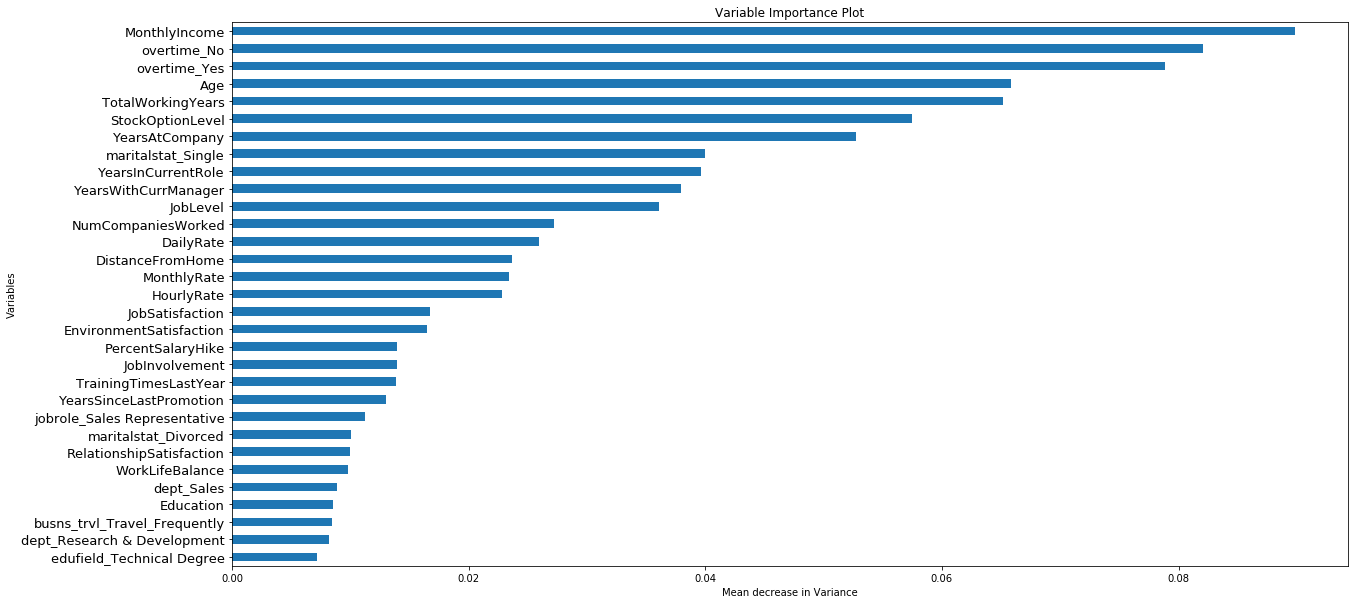

In [19]:
# Plot of Variable importance by mean decrease in gini
model_ranks = pd.Series(rf_fit.feature_importances_,index=x_train.columns, name='Importance').sort_values(ascending=False, inplace=False)
model_ranks.index.name = 'Variables'
top_features = model_ranks.iloc[:31].sort_values(ascending=True,inplace=False)
plt.figure(figsize=(20,10))
ax = top_features.plot(kind='barh')
_ = ax.set_title("Variable Importance Plot")
_ = ax.set_xlabel('Mean decrease in Variance')
_ = ax.set_yticklabels(top_features.index, fontsize=13)


In [20]:
# Random Forest Classifier - Grid Search
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV

pipeline = Pipeline([
        ('clf',RandomForestClassifier(criterion='gini',class_weight = {0:0.3,1:0.7}))])

parameters = {
        'clf__n_estimators':(2000,3000,5000),
        'clf__max_depth':(5,15,30),
        'clf__min_samples_split':(2,3),
        'clf__min_samples_leaf':(1,2)  }

grid_search = GridSearchCV(pipeline,parameters,n_jobs=-1,cv=5,verbose=1,scoring='accuracy')
grid_search.fit(x_train,y_train)

print ('Best Training score: %0.3f' % grid_search.best_score_)
print ('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (param_name, best_parameters[param_name]))

predictions = grid_search.predict(x_test)

print ("Testing accuracy:",round(accuracy_score(y_test, predictions),4))
print ("\nComplete report of Testing data\n",classification_report(y_test, predictions))
print ("\n\nRandom Forest Grid Search- Test Confusion Matrix\n\n",pd.crosstab(y_test, predictions,rownames = ["Actuall"],colnames = ["Predicted"]))      

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 11.5min finished


Best Training score: 0.868
Best parameters set:
	clf__max_depth: 5
	clf__min_samples_leaf: 1
	clf__min_samples_split: 2
	clf__n_estimators: 2000
Testing accuracy: 0.873

Complete report of Testing data
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       380
           1       0.63      0.20      0.30        61

    accuracy                           0.87       441
   macro avg       0.76      0.59      0.62       441
weighted avg       0.85      0.87      0.84       441



Random Forest Grid Search- Test Confusion Matrix

 Predicted    0   1
Actuall           
0          373   7
1           49  12


In [21]:
# Adaboost Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
dtree = DecisionTreeClassifier(criterion='gini',max_depth=1)

adabst_fit = AdaBoostClassifier(base_estimator= dtree,
        n_estimators=5000,learning_rate=0.05,random_state=42)

adabst_fit.fit(x_train, y_train)

print ("\nAdaBoost - Train Confusion Matrix\n\n",pd.crosstab(y_train,adabst_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nAdaBoost  - Train accuracy",round(accuracy_score(y_train,adabst_fit.predict(x_train)),3))
print ("\nAdaBoost  - Train Classification Report\n",classification_report(y_train,adabst_fit.predict(x_train)))

print ("\n\nAdaBoost  - Test Confusion Matrix\n\n",pd.crosstab(y_test,adabst_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nAdaBoost  - Test accuracy",round(accuracy_score(y_test,adabst_fit.predict(x_test)),3))
print ("\nAdaBoost - Test Classification Report\n",classification_report(y_test,adabst_fit.predict(x_test)))


AdaBoost - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          844    9
1           55  121

AdaBoost  - Train accuracy 0.938

AdaBoost  - Train Classification Report
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       853
           1       0.93      0.69      0.79       176

    accuracy                           0.94      1029
   macro avg       0.93      0.84      0.88      1029
weighted avg       0.94      0.94      0.93      1029



AdaBoost  - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          360  20
1           38  23

AdaBoost  - Test accuracy 0.868

AdaBoost - Test Classification Report
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       380
           1       0.53      0.38      0.44        61

    accuracy                           0.87       441
   macro avg       0.72      0.66      0.68       441
weighted avg       0.

In [22]:
# Gradientboost Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbc_fit = GradientBoostingClassifier(loss='deviance',learning_rate=0.05,n_estimators=5000,
                                     min_samples_split=2,min_samples_leaf=1,max_depth=1,random_state=42 )
gbc_fit.fit(x_train,y_train)

print ("\nGradient Boost - Train Confusion Matrix\n\n",pd.crosstab(y_train,gbc_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nGradient Boost - Train accuracy",round(accuracy_score(y_train,gbc_fit.predict(x_train)),3))
print ("\nGradient Boost  - Train Classification Report\n",classification_report(y_train,gbc_fit.predict(x_train)))

print ("\n\nGradient Boost - Test Confusion Matrix\n\n",pd.crosstab(y_test,gbc_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nGradient Boost - Test accuracy",round(accuracy_score(y_test,gbc_fit.predict(x_test)),3))
print ("\nGradient Boost - Test Classification Report\n",classification_report(y_test,gbc_fit.predict(x_test)))


Gradient Boost - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          850    3
1           49  127

Gradient Boost - Train accuracy 0.949

Gradient Boost  - Train Classification Report
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       853
           1       0.98      0.72      0.83       176

    accuracy                           0.95      1029
   macro avg       0.96      0.86      0.90      1029
weighted avg       0.95      0.95      0.95      1029



Gradient Boost - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          362  18
1           37  24

Gradient Boost - Test accuracy 0.875

Gradient Boost - Test Classification Report
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       380
           1       0.57      0.39      0.47        61

    accuracy                           0.88       441
   macro avg       0.74      0.67      0.7

In [ ]:
# Xgboost Classifier
import xgboost as xgb

xgb_fit = xgb.XGBClassifier(max_depth=2, n_estimators=5000, learning_rate=0.05)
xgb_fit.fit(x_train, y_train)

print ("\nXGBoost - Train Confusion Matrix\n\n",pd.crosstab(y_train,xgb_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nXGBoost - Train accuracy",round(accuracy_score(y_train,xgb_fit.predict(x_train)),3))
print ("\nXGBoost  - Train Classification Report\n",classification_report(y_train,xgb_fit.predict(x_train)))

print ("\n\nXGBoost - Test Confusion Matrix\n\n",pd.crosstab(y_test,xgb_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nXGBoost - Test accuracy",round(accuracy_score(y_test,xgb_fit.predict(x_test)),3))
print ("\nXGBoost - Test Classification Report\n",classification_report(y_test,xgb_fit.predict(x_test)))

In [23]:
#Ensemble of Ensembles - by fitting various classifiers
clwght = {0:0.3,1:0.7}

# Classifier 1
from sklearn.linear_model import LogisticRegression
clf1_logreg_fit = LogisticRegression(fit_intercept=True,class_weight=clwght)
clf1_logreg_fit.fit(x_train,y_train)

print ("\nLogistic Regression for Ensemble - Train Confusion Matrix\n\n",pd.crosstab(y_train,clf1_logreg_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nLogistic Regression for Ensemble - Train accuracy",round(accuracy_score(y_train,clf1_logreg_fit.predict(x_train)),3))
print ("\nLogistic Regression for Ensemble - Train Classification Report\n",classification_report(y_train,clf1_logreg_fit.predict(x_train)))

print ("\n\nLogistic Regression for Ensemble - Test Confusion Matrix\n\n",pd.crosstab(y_test,clf1_logreg_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nLogistic Regression for Ensemble - Test accuracy",round(accuracy_score(y_test,clf1_logreg_fit.predict(x_test)),3))
print ("\nLogistic Regression for Ensemble - Test Classification Report\n",classification_report(y_test,clf1_logreg_fit.predict(x_test)))


# Classifier 2
from sklearn.tree import DecisionTreeClassifier
clf2_dt_fit = DecisionTreeClassifier(criterion="gini",max_depth=5,min_samples_split=2,
                                     min_samples_leaf=1,random_state=42,class_weight=clwght)
clf2_dt_fit.fit(x_train,y_train)

print ("\nDecision Tree for Ensemble - Train Confusion Matrix\n\n",pd.crosstab(y_train,clf2_dt_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nDecision Tree for Ensemble - Train accuracy",round(accuracy_score(y_train,clf2_dt_fit.predict(x_train)),3))
print ("\nDecision Tree for Ensemble - Train Classification Report\n",classification_report(y_train,clf2_dt_fit.predict(x_train)))

print ("\n\nDecision Tree for Ensemble - Test Confusion Matrix\n\n",pd.crosstab(y_test,clf2_dt_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nDecision Tree for Ensemble - Test accuracy",round(accuracy_score(y_test,clf2_dt_fit.predict(x_test)),3))
print ("\nDecision Tree for Ensemble - Test Classification Report\n",classification_report(y_test,clf2_dt_fit.predict(x_test)))


# Classifier 3
from sklearn.ensemble import RandomForestClassifier
clf3_rf_fit = RandomForestClassifier(n_estimators=10000,criterion="gini",max_depth=6,
                                min_samples_split=2,min_samples_leaf=1,class_weight = clwght)
clf3_rf_fit.fit(x_train,y_train)       

print ("\nRandom Forest for Ensemble - Train Confusion Matrix\n\n",pd.crosstab(y_train,clf3_rf_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nRandom Forest for Ensemble - Train accuracy",round(accuracy_score(y_train,clf3_rf_fit.predict(x_train)),3))
print ("\nRandom Forest for Ensemble - Train Classification Report\n",classification_report(y_train,clf3_rf_fit.predict(x_train)))

print ("\n\nRandom Forest for Ensemble - Test Confusion Matrix\n\n",pd.crosstab(y_test,clf3_rf_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nRandom Forest for Ensemble - Test accuracy",round(accuracy_score(y_test,clf3_rf_fit.predict(x_test)),3))
print ("\nRandom Forest for Ensemble - Test Classification Report\n",classification_report(y_test,clf3_rf_fit.predict(x_test)))


# Classifier 4
from sklearn.ensemble import AdaBoostClassifier
clf4_dtree = DecisionTreeClassifier(criterion='gini',max_depth=1,class_weight = clwght)
clf4_adabst_fit = AdaBoostClassifier(base_estimator= clf4_dtree,
        n_estimators=5000,learning_rate=0.05,random_state=42)

clf4_adabst_fit.fit(x_train, y_train)

print ("\nAdaBoost for Ensemble  - Train Confusion Matrix\n\n",pd.crosstab(y_train,clf4_adabst_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nAdaBoost for Ensemble   - Train accuracy",round(accuracy_score(y_train,clf4_adabst_fit.predict(x_train)),3))
print ("\nAdaBoost for Ensemble   - Train Classification Report\n",classification_report(y_train,clf4_adabst_fit.predict(x_train)))

print ("\n\nAdaBoost for Ensemble   - Test Confusion Matrix\n\n",pd.crosstab(y_test,clf4_adabst_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nAdaBoost for Ensemble   - Test accuracy",round(accuracy_score(y_test,clf4_adabst_fit.predict(x_test)),3))
print ("\nAdaBoost for Ensemble  - Test Classification Report\n",classification_report(y_test,clf4_adabst_fit.predict(x_test)))


ensemble = pd.DataFrame()

ensemble["log_output_one"] = pd.DataFrame(clf1_logreg_fit.predict_proba(x_train))[1]
ensemble["dtr_output_one"] = pd.DataFrame(clf2_dt_fit.predict_proba(x_train))[1]
ensemble["rf_output_one"] = pd.DataFrame(clf3_rf_fit.predict_proba(x_train))[1]
ensemble["adb_output_one"] = pd.DataFrame(clf4_adabst_fit.predict_proba(x_train))[1]

ensemble = pd.concat([ensemble,pd.DataFrame(y_train).reset_index(drop = True )],axis=1)

# Fitting meta-classifier
meta_logit_fit =  LogisticRegression(fit_intercept=False)
meta_logit_fit.fit(ensemble[['log_output_one','dtr_output_one','rf_output_one','adb_output_one']],ensemble['Attrition_ind'])

coefs =  meta_logit_fit.coef_
print ("Co-efficients for LR, DT, RF & AB are:",coefs)

ensemble_test = pd.DataFrame()
ensemble_test["log_output_one"] = pd.DataFrame(clf1_logreg_fit.predict_proba(x_test))[1]
ensemble_test["dtr_output_one"] = pd.DataFrame(clf2_dt_fit.predict_proba(x_test))[1]
ensemble_test["rf_output_one"] = pd.DataFrame(clf3_rf_fit.predict_proba(x_test))[1]
ensemble_test["adb_output_one"] = pd.DataFrame(clf4_adabst_fit.predict_proba(x_test))[1]

ensemble_test["all_one"] = meta_logit_fit.predict(ensemble_test[['log_output_one','dtr_output_one','rf_output_one','adb_output_one']])

ensemble_test = pd.concat([ensemble_test,pd.DataFrame(y_test).reset_index(drop = True )],axis=1)

print ("\n\nEnsemble of Models - Test Confusion Matrix\n\n",pd.crosstab(ensemble_test['Attrition_ind'],ensemble_test['all_one'],rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nEnsemble of Models - Test accuracy",round(accuracy_score(ensemble_test['Attrition_ind'],ensemble_test['all_one']),3))
print ("\nEnsemble of Models - Test Classification Report\n",classification_report(ensemble_test['Attrition_ind'],ensemble_test['all_one']))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Logistic Regression for Ensemble - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          783   70
1           62  114

Logistic Regression for Ensemble - Train accuracy 0.872

Logistic Regression for Ensemble - Train Classification Report
               precision    recall  f1-score   support

           0       0.93      0.92      0.92       853
           1       0.62      0.65      0.63       176

    accuracy                           0.87      1029
   macro avg       0.77      0.78      0.78      1029
weighted avg       0.87      0.87      0.87      1029



Logistic Regression for Ensemble - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          338  42
1           31  30

Logistic Regression for Ensemble - Test accuracy 0.834

Logistic Regression for Ensemble - Test Classification Report
               precision    recall  f1-score   support

           0       0.92      0.89      0.90       380
           1       0.42      0.49      0.45 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Co-efficients for LR, DT, RF & AB are: [[ 0.88635205  1.10978968  6.58313783 -8.23962512]]


Ensemble of Models - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          368  12
1           42  19

Ensemble of Models - Test accuracy 0.878

Ensemble of Models - Test Classification Report
               precision    recall  f1-score   support

           0       0.90      0.97      0.93       380
           1       0.61      0.31      0.41        61

    accuracy                           0.88       441
   macro avg       0.76      0.64      0.67       441
weighted avg       0.86      0.88      0.86       441



In [24]:
# Ensemble of Ensembles - by applying bagging on simple classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

clwght = {0:0.3,1:0.7}

eoe_dtree = DecisionTreeClassifier(criterion='gini',max_depth=1,class_weight = clwght)
eoe_adabst_fit = AdaBoostClassifier(base_estimator= eoe_dtree,
        n_estimators=500,learning_rate=0.05,random_state=42)
eoe_adabst_fit.fit(x_train, y_train)

print ("\nAdaBoost - Train Confusion Matrix\n\n",pd.crosstab(y_train,eoe_adabst_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nAdaBoost - Train accuracy",round(accuracy_score(y_train,eoe_adabst_fit.predict(x_train)),3))
print ("\nAdaBoost  - Train Classification Report\n",classification_report(y_train,eoe_adabst_fit.predict(x_train)))

print ("\n\nAdaBoost - Test Confusion Matrix\n\n",pd.crosstab(y_test,eoe_adabst_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nAdaBoost - Test accuracy",round(accuracy_score(y_test,eoe_adabst_fit.predict(x_test)),3))
print ("\nAdaBoost - Test Classification Report\n",classification_report(y_test,eoe_adabst_fit.predict(x_test)))


bag_fit = BaggingClassifier(base_estimator= eoe_adabst_fit,n_estimators=50,
                            max_samples=1.0,max_features=1.0,
                            bootstrap=True,
                            bootstrap_features=False,
                            n_jobs=-1,
                            random_state=42)

bag_fit.fit(x_train, y_train)

print ("\nEnsemble of AdaBoost - Train Confusion Matrix\n\n",pd.crosstab(y_train,bag_fit.predict(x_train),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nEnsemble of AdaBoost - Train accuracy",round(accuracy_score(y_train,bag_fit.predict(x_train)),3))
print ("\nEnsemble of AdaBoost  - Train Classification Report\n",classification_report(y_train,bag_fit.predict(x_train)))

print ("\n\nEnsemble of AdaBoost - Test Confusion Matrix\n\n",pd.crosstab(y_test,bag_fit.predict(x_test),rownames = ["Actuall"],colnames = ["Predicted"]))      
print ("\nEnsemble of AdaBoost - Test accuracy",round(accuracy_score(y_test,bag_fit.predict(x_test)),3))
print ("\nEnsemble of AdaBoost - Test Classification Report\n",classification_report(y_test,bag_fit.predict(x_test)))


AdaBoost - Train Confusion Matrix

 Predicted    0    1
Actuall            
0          806   47
1           63  113

AdaBoost - Train accuracy 0.893

AdaBoost  - Train Classification Report
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       853
           1       0.71      0.64      0.67       176

    accuracy                           0.89      1029
   macro avg       0.82      0.79      0.80      1029
weighted avg       0.89      0.89      0.89      1029



AdaBoost - Test Confusion Matrix

 Predicted    0   1
Actuall           
0          349  31
1           34  27

AdaBoost - Test accuracy 0.853

AdaBoost - Test Classification Report
               precision    recall  f1-score   support

           0       0.91      0.92      0.91       380
           1       0.47      0.44      0.45        61

    accuracy                           0.85       441
   macro avg       0.69      0.68      0.68       441
weighted avg       0.85 